In [18]:
import torch, torch.utils.data
from torch import nn
import torchvision, torchvision.datasets
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import List
import sys
sys.path.append('./fedlab/main/fedlab_benchmarks/leaf/')

sys.path.append('./fedlab/main/fedlab_benchmarks/')

sys.path.append('./fedlab/main/')

sys.path.append('./fedlab/')

from fedlab.main.fedlab_benchmarks.leaf.dataloader import get_LEAF_dataloader

from torch.profiler import profile, record_function, ProfilerActivity
import time
from sklearn.metrics import f1_score   
import numpy as np
    
import random

In [19]:
print(torch.__version__)




2.0.0


In [20]:

train_loaders = []
test_loaders = []
num_nodes = 5
num_class = 10
epoch_total = 2
pickle_name = "mnist-p2p-epoch-"+str(epoch_total)

In [21]:
device = torch.device('cuda')
torch.cuda.get_device_name(device)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [22]:

transform = transforms.Compose([
    transforms.ToTensor(),
])
target_transform = lambda x: torch.nn.functional.one_hot(torch.tensor(x),num_class).float()

In [23]:
# def split_dataset(dataset, n):
#     torch.utils.data.random_split(dataset, )

In [24]:
# train_dataset2 = torchvision.datasets.MNIST('datasets/', download=True, train=True, transform=transform, target_transform=target_transform),
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000000, num_workers=0)

# test_dataset = torchvision.datasets.MNIST('datasets/', download=True, train=False, transform=transform, target_transform=target_transform)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000000, num_workers=0)


# Inital MNIST
train_datasets = torch.utils.data.random_split(torchvision.datasets.MNIST('datasets/',
                                                                           download=True, train=True, transform=transform, target_transform=target_transform), [1/num_nodes]*num_nodes)
test_datasets = torch.utils.data.random_split(torchvision.datasets.MNIST('datasets/',
                                                                           download=True, train=False, transform=transform, target_transform=target_transform), [1/num_nodes]*num_nodes)

train_loaders = [torch.utils.data.DataLoader(i, batch_size=1000000, num_workers=0) for i in train_datasets]
test_loaders = [torch.utils.data.DataLoader(i, batch_size=1000000, num_workers=0) for i in test_datasets]


In [25]:
print(len(train_loaders))
print(len(test_loaders))
print(test_loaders)
print(len(test_loaders[0].dataset))

5
5
[<torch.utils.data.dataloader.DataLoader object at 0x7f508d3d6620>, <torch.utils.data.dataloader.DataLoader object at 0x7f508d3d5c00>, <torch.utils.data.dataloader.DataLoader object at 0x7f508d3d7ca0>, <torch.utils.data.dataloader.DataLoader object at 0x7f508d3d7ee0>, <torch.utils.data.dataloader.DataLoader object at 0x7f508d3d7eb0>]
2000


In [26]:

x_i_j = {}
s_i = {}

ypred = []
ylabels = []

In [27]:
class FederatedNode:
    def __init__(self, train_dataloader, test_dataloader, node_id) -> None:
        self.dataset_size = len(train_dataloader.dataset)
        channels_sum, channels_squared_sum, num_batches = 0, 0, 0
        for data, _ in train_dataloader:
            # Mean over batch, height and width, but not over the channels
            channels_sum += torch.mean(data, dim=[0])
            channels_squared_sum += torch.mean(data**2, dim=[0])
            num_batches += 1
    
        self.mean = channels_sum / num_batches
        self.test_loss = 0.0
        self.test_accuracy = 0.0
        self.train_accuracy = 0.0
        self.train_loss = 0.0
        self.f1_score = 0.0


        # std = sqrt(E[X^2] - (E[X])^2)
        self.std = (channels_squared_sum / num_batches - self.mean ** 2) ** 0.5
        print("Dataset size ", self.dataset_size)
        print("Mean size ", self.mean.shape)
        print("Standard deviation size ", self.std.shape)
        
        
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784,56),
            nn.ReLU(),
            nn.Linear(56, 10)
        ).to(device)

        '''
        only_digits=False
        self.network = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(9216, 128),
        nn.Dropout(0.5),
        nn.Linear(128, 10 if only_digits else 62),
        nn.ReLU()
        ).to(device)
        '''
        self.optimizer = torch.optim.Adam(self.network.parameters())
        self.criterion = nn.CrossEntropyLoss()
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.node_id = node_id
    
    def train_epoch(self):
        losses = []
        correct = 0
        total = 0
        train_accuracy = []
        for idx, (data_x, data_y) in enumerate(self.train_dataloader):
            #print("data_x", data_x.shape)
            #print("data_y", data_y.shape)
            #plt.imshow(data_x[1][0])
            output = self.network(data_x.to(device))
            self.optimizer.zero_grad()
            #print(output.shape)
            #print(data_y)
            #data_y = target_transform(data_y)
            
            #loss = nn.functional.mse_loss(output, data_y.to(device))
            loss = self.criterion(output, data_y.to(device))
            losses.append(loss.item())
            loss.backward()
            self.optimizer.step()

            _, predicted = torch.max(output.data, 1)
            data_y = data_y.to(predicted.device)
            true_labels = torch.argmax(data_y, dim=1).to(predicted.device)
            total += data_y.size(0)
            correct += (predicted == true_labels).sum().item()
            train_accuracy.append(correct / total)
            ypred.append(data_y)
            ylabels.append(true_labels)
        self.train_accuracy = train_accuracy[-1]
        self.train_loss = sum(losses)/len(losses)
        return self.train_accuracy, self.train_loss
    
    def testing(self):
        correct = 0
        total = 0
        # test_running_loss = 0.0
        predictions = []
        labels = []
        test_accuracy = []
        test_running_losses = []
        for idx, (data_x, data_y) in enumerate(self.test_dataloader):
            output = self.network(data_x.to(device))
            
            _, predicted = torch.max(output.data, 1)
            data_y = data_y.to(predicted.device)
            true_labels = torch.argmax(data_y, dim=1).to(predicted.device)
            total += data_y.size(0)
            correct += (predicted == true_labels).sum().item()
            
            loss = self.criterion(output, data_y)
            predictions.append(predicted.cpu())
            #labels.append(data_y.cpu())
            labels.append(true_labels.cpu())
            test_running_losses.append(loss.item())
            #print('Epoch %d test loss: %.3f' % (idx + 1, test_running_losses[-1]))
            #print(test_running_losses)
            #test_running_loss += loss.item()
            #test_loss.append(test_running_loss / len(self.test_dataloader))
            test_accuracy.append(correct / total)
        
        #print(predictions)
        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        self.f1_score= f1_score(labels, predictions, average="weighted")
        self.test_accuracy = test_accuracy[-1]
        #print(self.test_accuracy)
        self.test_loss =  sum(test_running_losses)/len(test_running_losses)
        #print("test loss ",self.test_loss)
       
    
    def share_x_ij(self):
        x = self.network.state_dict()
        r = torch.randint(0, 5, [num_nodes])
        s_r = torch.sum(r)
        j=self.node_id
        for i in range(num_nodes):
            x_i_j[(i,j)]={}
            for key in x.keys():
                x_i_j[(i,j)][key]=x[key]*r[i]/s_r
                
        
    
    def share_s_i(self):
        i = self.node_id
        s_i[i] = {}
        for key in x_i_j[(0,0)].keys():
            s_i[i][key] = sum([x_i_j[(i,j)][key] for j in range(num_nodes)])


In [28]:
#for i, loader_data in enumerate(zip(*loader)):
#    train_loaders, test_loaders = loader_data

nodes = []
for i in range(num_nodes):
    nodes.append(FederatedNode(train_loaders[i], test_loaders[i], i)) 

#nodes = [FederatedNode(l, i) for i,l in enumerate())]

Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])


In [29]:
losses = {}
train_accuracies = {}
test_accuracies = {}
test_losses = {}
f1_scores = {}
#with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
#    with record_function("model_training"):

start_time = time.time()
dataset_size_all = {}
epochs ={i:0 for i in range(num_nodes)}

for i in tqdm(range(epoch_total*num_nodes)):
    cands = [i for i in epochs if epochs[i]<epoch_total]
    picked_node = nodes[cands[torch.randint(len(cands), (1,)).item()]]
    del cands
    train_acc, loss = picked_node.train_epoch()
    #node.share_FedavgP2P(nodes)

    x_i_j = {}
    s_i = {}
    for node in nodes:
        node.share_x_ij()
    
    for node in nodes:
        node.share_s_i()
        
    
    epochs[picked_node.node_id] += 1
    losses[(picked_node.node_id, epochs[picked_node.node_id])]=loss
    train_accuracies[(picked_node.node_id, epochs[picked_node.node_id])]=train_acc

    for i, node in enumerate(nodes):
        #print()
        #print("Node ", i)
        
        node.testing()
        #test_losses.append(node.test_loss)
        #print("Node Test Accuracy", node.test_accuracy)
        #print("Node Test loss", node.test_loss)
        #print("Node F1_Score ", node.f1_score)
        test_accuracies[(node.node_id, epochs[node.node_id])]=node.test_accuracy
        test_losses[(node.node_id, epochs[node.node_id])]=node.test_loss
        f1_scores[(node.node_id, epochs[node.node_id])]=node.f1_score
        

            
    # test_accuracies.append(epoch_test_accuracies)
    # test_losses.append(epoch_test_losses)
    # f1_scores.append(epoch_f1_scores)


    
    #av_state = {}
    #print(s_i[0])
    #for key in s_i[0].keys():
    #    av_state[key]=torch.mean(torch.tensor([s_i[i][key] for i in s_i]), dim=[0])
    averaged_state = {}
    for key in s_i[0].keys():
        param_value = 0
        for i in s_i:
            param_value += s_i[i][key]
        
        averaged_state[key] = param_value/num_nodes

    for node in nodes:
        node.network.load_state_dict(averaged_state)

    
    
    
    # states = [i.network.state_dict() for i in nodes]
    # av_state = {}
    # for key in states[0]:
    #     av_state[key] = sum([s[key] for s in states])/num_nodes
    # for node in nodes:
    #     node.network.load_state_dict(av_state)

time_FL_SMPC = time.time() - start_time

print("Time taken by FL with SMPC", time_FL_SMPC)
    


100%|██████████| 10/10 [00:32<00:00,  3.29s/it]

Time taken by FL with SMPC 32.9178102016449


In [30]:
losses

{(1, 1): 2.3123490810394287,
 (3, 1): 2.3014273643493652,
 (0, 1): 2.2982983589172363,
 (3, 2): 2.2948081493377686,
 (1, 2): 2.291337251663208,
 (4, 1): 2.288804054260254,
 (2, 1): 2.285423517227173,
 (4, 2): 2.280870199203491,
 (0, 2): 2.277116298675537,
 (2, 2): 2.2730257511138916}

In [31]:
losses2 = [[losses[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
train_accuracies2 = [[train_accuracies[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
test_accuracies2 = [[test_accuracies[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
test_losses2 = [[test_losses[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]
f1_scores2 = [[f1_scores[(j,i)] for j in range(num_nodes) ] for i in range(1,epoch_total+1)]

In [32]:
import pickle

try:
    my_pickle_results = pickle.load( open( pickle_name+'.pickle', "rb" ) )
    result = {}
    result2 = {}
    myResults = my_pickle_results
except (OSError, IOError) as e:
    my_pickle_results = {}
    result = {}
    result2 = {}

In [33]:
result["train_accuracies"] = train_accuracies2
result["train_losses"] = losses2
result["test_accuracies"] = test_accuracies2
result["test_losses"] = test_losses2
result["f1_scores"] = f1_scores2
result["ypred"] = ypred
result["ylabels"] = ylabels
result["time_taken"] = time_FL_SMPC


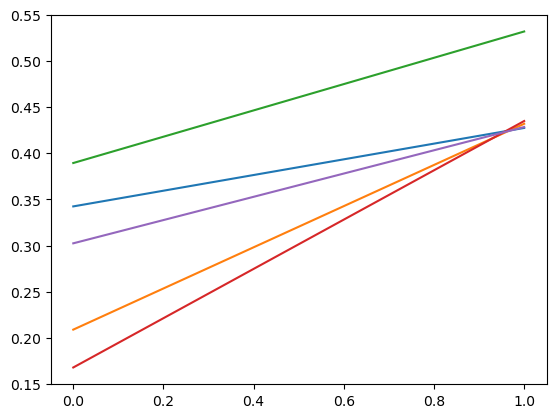

In [34]:
plt.plot(test_accuracies2)

In [35]:
print(losses2)

[[2.2982983589172363, 2.3123490810394287, 2.285423517227173, 2.3014273643493652, 2.288804054260254], [2.277116298675537, 2.291337251663208, 2.2730257511138916, 2.2948081493377686, 2.280870199203491]]


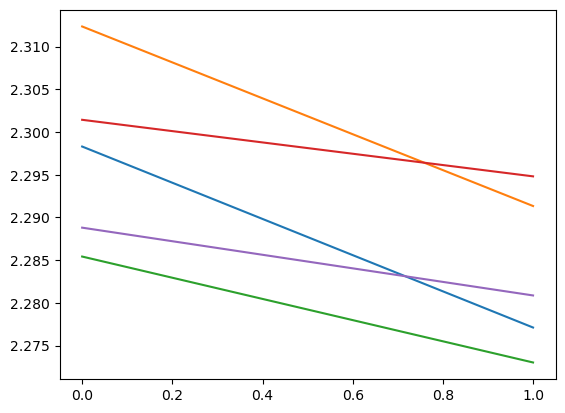

In [36]:
plt.plot(losses2)

In [37]:

nodes = []
for i in range(num_nodes):
    nodes.append(FederatedNode(train_loaders[i], test_loaders[i], i)) 


Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])
Dataset size  12000
Mean size  torch.Size([1, 28, 28])
Standard deviation size  torch.Size([1, 28, 28])


In [38]:
with open(pickle_name+'.pickle', 'wb') as handle:
    pickle.dump(my_pickle_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
labels = []
for _, label in train_loaders[0]:
    labels.append(label)
#print(labels)
#print(classification_report(y_true, y_pred, target_names=target_names))

In [40]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2023-05-12 21:49:03
